## Project description

In this project I will analyize a sample of the hungarian poetry to anwser the following questions:

Q1. Sentiment analysis:
- What is the general sentiment of Hungarian poetry?
- Which of our authors are the most cheerfull adn which ones arethe most gloomy?
- Is there a trend in time of sentiment changing?

Q2. Classifiation:
- Can poetry be classified using a Naive-Bayes algoryth?

#### Data used

ELTE, a hungarian university collected poems from the most popular hungarian authors (https://verskorpusz.elte-dh.hu/view.php? id=3051)

#### Chapters and summary

During the project I did the following steps:
- Creating the dataframes: scraping the poems and the year of birth of the authors
- Exploring the data: checking missing data, excluding too long poems, checking data type of columns, checking key distributions and value counts
- Q1: Sentiment analysis: cleaning the hungarian text (punctuation, non-letter characters, stopwords, lower casing), translating it to english via google translator function, cleaning again, lemmatizing and sentiment analysis per century and per author
- Q2: Classification via Naive-Bayes and evaluation with confusion matrix for 3 top authors

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### 1. Creating the dataframes

#### 1.1 Loading the dataset

I loaded the dataset that I downloaded (https://verskorpusz.elte-dh.hu/view.php?id=3051) into Jupite. 

- The dataset has c.13.000 rows, and each row is a poem.
- It has 3 columns: author, title of the poem, and an url to the poem text

In [2]:
df = pd.read_csv("./talalatok.tsv", sep='\t')
df = pd.DataFrame(df)
df = df.rename(columns={"Szerző":"author", "Műcím":"title", "Webcím":"url"})
df

,author,title,url
0,Ady Endre,»A BÁNAT DALAI«-BÓL,https://verskorpusz.elte-dh.hu/view.php?id=1858
1,Ady Endre,»A XXX-IK SZÁZADBÓL«,https://verskorpusz.elte-dh.hu/view.php?id=1458
2,Ady Endre,"»ÁDÁM, HOL VAGY?«",https://verskorpusz.elte-dh.hu/view.php?id=1304
3,Ady Endre,»ADÁNAK«,https://verskorpusz.elte-dh.hu/view.php?id=1636
4,Ady Endre,"»ÖRVENDEZZ, IFJÚ, IFJÚSÁGODBAN«",https://verskorpusz.elte-dh.hu/view.php?id=1325
...,...,...,...
13059,Zrínyi Miklós,NEM IROM PENNÁVAL...,https://verskorpusz.elte-dh.hu/view.php?id=5486
13060,Zrínyi Miklós,PERORATIO,https://verskorpusz.elte-dh.hu/view.php?id=5474
13061,Zrínyi Miklós,RADIVOJ ÉS JURANICS VAJDÁK,https://verskorpusz.elte-dh.hu/view.php?id=5478
13062,Zrínyi Miklós,Szigeti veszedelem,https://verskorpusz.elte-dh.hu/view.php?id=5473


Let's check the number of poems per artist. We see a very uneven distribution with a long right tale: Some authory have less than 10 poems in the dataset. Looking at these authors, the reason for this is that they are either writers and not poets, or from 16-17th century, with little known poems. So this is likely not a mistake in the dataset

<AxesSubplot:title={'center':'Poems by author'}>

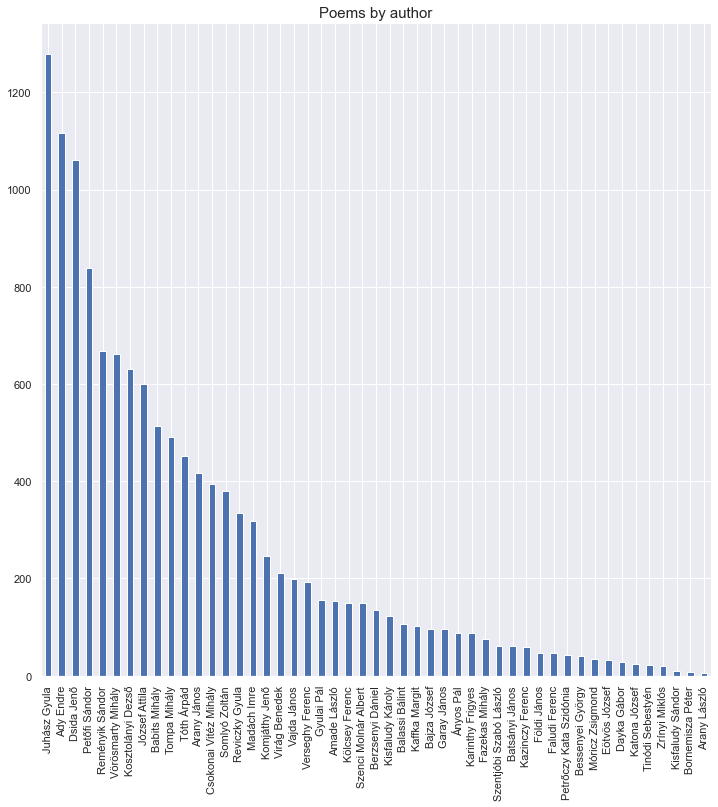

In [3]:
plt.figure(figsize=(12,12))
plt.title("Poems by author",fontsize=15)
df['author'].value_counts()[0:50].plot(kind='bar')

#### 1.2 Creating authors dataframe to scrape their year of birth

I needed to scrape the year of birth of each author to do an analysis on how sentiment changed through time. I created a separate dataframe with the authors only, and the number of the poems they wrote.

In [4]:
authors = df[["author", "url"]].groupby("author").count().sort_values(['url'], ascending=[False])
authors.reset_index(inplace=True)
authors

,author,url
0,Juhász Gyula,1278
1,Ady Endre,1116
2,Dsida Jenő,1060
3,Petőfi Sándor,839
4,Reményik Sándor,667
5,Vörösmarty Mihály,662
6,Kosztolányi Dezső,630
7,József Attila,599
8,Babits Mihály,514
9,Tompa Mihály,491


#### 1.3 Scraping the birth year of authors

I included the date of birth into this table by scraping the name of authors from google and extracting the date of birth fom the search result

In [5]:
def find_year(author):
    headers = {'Cookie':'CONSENT=YES+cb.20210418-17-p0.it+FX+917;'}
    url = ("https://www.google.com/search?q={}+született".format(author))
    resp = requests.get(url, headers = headers)
    soup = BeautifulSoup(resp.text, 'html.parser')
    year = soup.find_all("div", class_="BNeawe iBp4i AP7Wnd")[1].text[0:4]
    return year

In [6]:
# authors["birth"] = authors["author"].apply(lambda x: find_year(x))
# authors

There are 2 missing years where the scraping did not work, I will impute these manually and save the dataset locally so I do not have to do the scraping again

In [7]:
# authors.at[38,'birth'] = 1658
# authors.at[43,'birth'] = 1510

In [8]:
# authors.to_csv('./authors.csv', index=False)

In [9]:
authors = pd.read_csv("./authors.csv")
authors

,author,url,birth
0,Juhász Gyula,128,1883
1,Ady Endre,112,1877
2,Dsida Jenő,106,1907
3,Petőfi Sándor,84,1823
4,Reményik Sándor,67,1890
5,Vörösmarty Mihály,66,1800
6,Kosztolányi Dezső,63,1885
7,József Attila,60,1905
8,Babits Mihály,51,1883
9,Tompa Mihály,49,1817


#### 1.4 Scraping the poems

Since there are 13000 poems in the dataset, and one poem could has 3-400 words at least, I would have a too large dataset to handle. So for the sake of simplicity, I randomly select 10% of poems from each author, leading to 1300 poems in total, an I will continute to analyise this subset only

In [10]:
df

,author,title,url
0,Ady Endre,»A BÁNAT DALAI«-BÓL,https://verskorpusz.elte-dh.hu/view.php?id=1858
1,Ady Endre,»A XXX-IK SZÁZADBÓL«,https://verskorpusz.elte-dh.hu/view.php?id=1458
2,Ady Endre,"»ÁDÁM, HOL VAGY?«",https://verskorpusz.elte-dh.hu/view.php?id=1304
3,Ady Endre,»ADÁNAK«,https://verskorpusz.elte-dh.hu/view.php?id=1636
4,Ady Endre,"»ÖRVENDEZZ, IFJÚ, IFJÚSÁGODBAN«",https://verskorpusz.elte-dh.hu/view.php?id=1325
...,...,...,...
13059,Zrínyi Miklós,NEM IROM PENNÁVAL...,https://verskorpusz.elte-dh.hu/view.php?id=5486
13060,Zrínyi Miklós,PERORATIO,https://verskorpusz.elte-dh.hu/view.php?id=5474
13061,Zrínyi Miklós,RADIVOJ ÉS JURANICS VAJDÁK,https://verskorpusz.elte-dh.hu/view.php?id=5478
13062,Zrínyi Miklós,Szigeti veszedelem,https://verskorpusz.elte-dh.hu/view.php?id=5473


Taking a sample from the whole dataset and saving it locally:

In [11]:
# import random

# df_sample = df[0:0] # creating empty dataframe

# for author in authors["author"]:
#     df_sample = df_sample.append(df[df["author"] == author].sample(frac=0.1))

# df_sample.to_csv('./df_sample.csv', index=False)
# df_sample

In [12]:
df_sample = pd.read_csv("./df_sample.csv")

Scraping the poems and saving them locally:

In [13]:
# poems = []
# poem = []

# for url in df_sample["url"]:
#    poem=[]
#    print(url)
#    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
#    for word in soup.find_all('span', class_='word'):
#        poem.append(word.text)
#    poems.append(" ".join(poem))

In [14]:
# df_sample["poem"] = poems
# df_sample.to_csv('./df_sample.csv', index=False)

The result of the scraping: A dataset of 1300 poems

In [15]:
df_sample = pd.read_csv("./df_sample.csv")
df_sample

,author,title,url,poem
0,Juhász Gyula,Révület,https://verskorpusz.elte-dh.hu/view.php?id=8593,Oly furcsa ez : szavak zengésein túl Keresni t...
1,Juhász Gyula,Férfikarének,https://verskorpusz.elte-dh.hu/view.php?id=9381,"Az életünk kertjében Sok szép virág terem , Az..."
2,Juhász Gyula,Louis D'Or,https://verskorpusz.elte-dh.hu/view.php?id=9480,"Az esti fényben sápadtan ragyog , Arany , aran..."
3,Juhász Gyula,Télutó,https://verskorpusz.elte-dh.hu/view.php?id=9726,Még benn ülünk . A kandalló varázsa Melengeti ...
4,Juhász Gyula,Az ismeretlenhez,https://verskorpusz.elte-dh.hu/view.php?id=9300,"Én néha már találkoztam veled . Nem ott , ahol..."
...,...,...,...,...
1305,Katona József,Ajándék,https://verskorpusz.elte-dh.hu/view.php?id=2401,"Lányka , még most is ragyog a szememben szíves..."
1306,Katona József,A Természethez,https://verskorpusz.elte-dh.hu/view.php?id=2388,"Melly szép vagy te , Természet ! szép Anyja a ..."
1307,Arany László,TŰNŐDÉS,https://verskorpusz.elte-dh.hu/view.php?id=5780,"Virrasztok árva lámpa mellett , Olyan nyomaszt..."
1308,Bornemisza Péter,Az ötkötetes prédikációskönyv verses idézete [2],https://verskorpusz.elte-dh.hu/view.php?id=12092,"Én császár nem lennék , hogy annyit fáradnék ,..."


#### 1.4 Merging the two dataframes

Now I join the dataframe on the poems with the dataframe on the authors to get the year of birth

In [16]:
df = pd.merge(df_sample, authors, how="left", on='author')
df = df.rename(columns={"url_x":"url"})
df = df.drop(["url", "url_y"], axis=1)
df

,author,title,poem,birth
0,Juhász Gyula,Révület,Oly furcsa ez : szavak zengésein túl Keresni t...,1883
1,Juhász Gyula,Férfikarének,"Az életünk kertjében Sok szép virág terem , Az...",1883
2,Juhász Gyula,Louis D'Or,"Az esti fényben sápadtan ragyog , Arany , aran...",1883
3,Juhász Gyula,Télutó,Még benn ülünk . A kandalló varázsa Melengeti ...,1883
4,Juhász Gyula,Az ismeretlenhez,"Én néha már találkoztam veled . Nem ott , ahol...",1883
...,...,...,...,...
1305,Katona József,Ajándék,"Lányka , még most is ragyog a szememben szíves...",1791
1306,Katona József,A Természethez,"Melly szép vagy te , Természet ! szép Anyja a ...",1791
1307,Arany László,TŰNŐDÉS,"Virrasztok árva lámpa mellett , Olyan nyomaszt...",1844
1308,Bornemisza Péter,Az ötkötetes prédikációskönyv verses idézete [2],"Én császár nem lennék , hogy annyit fáradnék ,...",1535


### 2. Data exploration

In this chapter I will explored the newly created dataset

#### 2.1 Checking whole data

There were no missing values

In [17]:
# no missing values
df.isna().sum(axis=0)

author    0
title     0
poem      0
birth     0
dtype: int64

I changed the data type of years to numbers

In [18]:
# checking data types
df.dtypes
df["birth"] = pd.to_numeric(df["birth"])
df.dtypes

author    object
title     object
poem      object
birth      int64
dtype: object

#### 2.1 Authors column

I checked the distribution of the sample per author. The sample has a similar distribution to the original dataset.

<AxesSubplot:title={'center':'Poems by author'}>

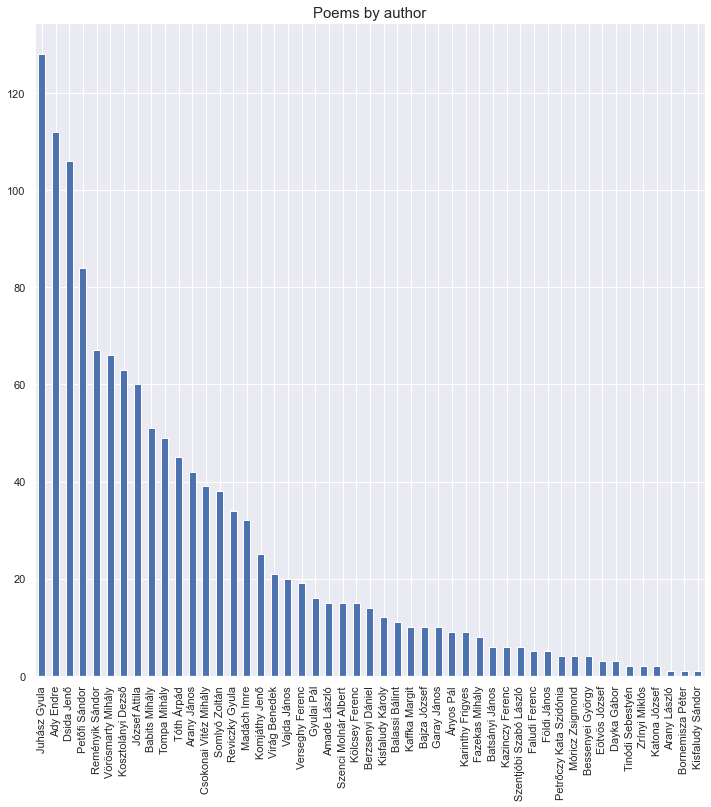

In [19]:
plt.figure(figsize=(12,12))
plt.title("Poems by author",fontsize=15)
df['author'].value_counts()[0:50].plot(kind='bar')

#### 2.2 Birth year column

I checked the distribution by birth year. Unfortunately the dataset is very unbalanced in terms of time coverage

<AxesSubplot:title={'center':'Poems by year'}, ylabel='Frequency'>

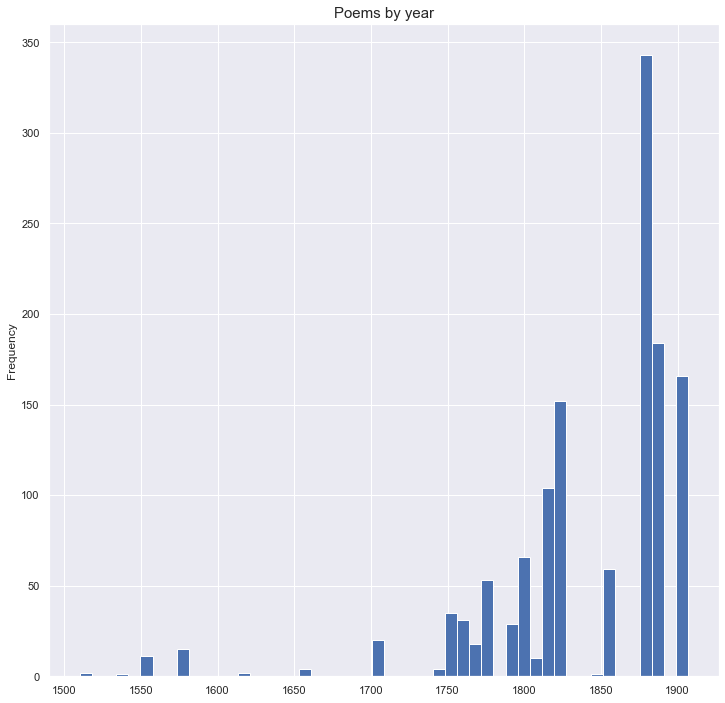

In [20]:
plt.figure(figsize=(12,12))
plt.title("Poems by year",fontsize=15)
df['birth'].plot(kind='hist', bins=50)

### Question 1 - Sentiment analysis

In this chapter I will examine the sentiment in general for the whole sample, by time, and by author.
I tried to anwser the following 3 question:
- What is the general sentiment of Hungarian poetry?
- Which of our authors are the most cheerfull adn which ones arethe most gloomy?
- Is there a trend in time of sentiment changing?

The key challange here is that hungarian language has no lammetization and no sentiment analysis. So I needed to trnslate the poems into english and analyze their sentiment there. However this is not an easy task with poems that use uncommon hungarian words in an uncommon order. I planned to translate a cleaned version word by word, but the google translation algorythm has a daily limit on requests, so translating c.700,000 words individually was not an potion. Instead I did the following steps:


- Cleaning the hungarian words:  Removing stopwords makes translation faster and easier so I cleaned poems from non-leter characters, shifted to lowe case, extracted stopwords using a standard stopwords list and adding some custom stopwords to it. 

- Translating text to english: I used a google translator algorythm to translate in 2 batches: First I run the translation function on all the poems with a try-else function, and then I did a second round of translating the poems that were excluded in the first round due to response issues. I then merged the 2 dataframes

- Cleaning translation: I again had to clean the translated text. As I could not translate word-by-word, but the whole poem, the translation included a lot of stopwords in english. I also did lemmatization.

- Sentiment analysis: I used vader sentiment analysis to get the sentiment of each poem. 

#### Cleaning hungarian poems

In [21]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import time

In [22]:
stopwords = stopwords.words('hungarian')

In [23]:
# adding custom stopwords
custom_words = ["ó", "kis", "en", "te","ot","előtt","ha", "mi","ti","ők", "őket", "oly"]
stopwords = stopwords + custom_words
stopwords

['a',
 'ahogy',
 'ahol',
 'aki',
 'akik',
 'akkor',
 'alatt',
 'által',
 'általában',
 'amely',
 'amelyek',
 'amelyekben',
 'amelyeket',
 'amelyet',
 'amelynek',
 'ami',
 'amit',
 'amolyan',
 'amíg',
 'amikor',
 'át',
 'abban',
 'ahhoz',
 'annak',
 'arra',
 'arról',
 'az',
 'azok',
 'azon',
 'azt',
 'azzal',
 'azért',
 'aztán',
 'azután',
 'azonban',
 'bár',
 'be',
 'belül',
 'benne',
 'cikk',
 'cikkek',
 'cikkeket',
 'csak',
 'de',
 'e',
 'eddig',
 'egész',
 'egy',
 'egyes',
 'egyetlen',
 'egyéb',
 'egyik',
 'egyre',
 'ekkor',
 'el',
 'elég',
 'ellen',
 'elõ',
 'elõször',
 'elõtt',
 'elsõ',
 'én',
 'éppen',
 'ebben',
 'ehhez',
 'emilyen',
 'ennek',
 'erre',
 'ez',
 'ezt',
 'ezek',
 'ezen',
 'ezzel',
 'ezért',
 'és',
 'fel',
 'felé',
 'hanem',
 'hiszen',
 'hogy',
 'hogyan',
 'igen',
 'így',
 'illetve',
 'ill.',
 'ill',
 'ilyen',
 'ilyenkor',
 'ison',
 'ismét',
 'itt',
 'jó',
 'jól',
 'jobban',
 'kell',
 'kellett',
 'keresztül',
 'keressünk',
 'ki',
 'kívül',
 'között',
 'közül',
 'lega

In [24]:
def text_preprocesser(text):
    text= re.sub(r'\W',' ', text)
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [word for word in tokens if len(word)>=3]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

In [25]:
# lets look at an example
text_preprocesser(df["poem"][5])

'mily szépen alkonyul végtelenség égen bíbor fekete zászlók vonulnak ünnepélyes komolyan napnak legutolsó sugarában rőt paripákon komor óriások ügetnek ismeretlen táj tavaszi égi háború zenék sírások törnek feléjük elboruló földről vonulnak némán kevélyen magasan dicsőn búsulva ciprus babér szeretnék tovaszállani velük nyomoron kínon túl engem porba vert sors égi zászlók lobognak óriások robognak sírom fölött szépen alkonyul végtelenség'

The cleaned dataframe

In [26]:
df_q1 = df
df_q1["poem_clean"] = df_q1["poem"].apply(lambda x: text_preprocesser(x))
df_q1

,author,title,poem,birth,poem_clean
0,Juhász Gyula,Révület,Oly furcsa ez : szavak zengésein túl Keresni t...,1883,furcsa szavak zengésein túl keresni titkot ben...
1,Juhász Gyula,Férfikarének,"Az életünk kertjében Sok szép virág terem , Az...",1883,életünk kertjében szép virág terem öröm baráts...
2,Juhász Gyula,Louis D'Or,"Az esti fényben sápadtan ragyog , Arany , aran...",1883,esti fényben sápadtan ragyog arany arany csill...
3,Juhász Gyula,Télutó,Még benn ülünk . A kandalló varázsa Melengeti ...,1883,benn ülünk kandalló varázsa melengeti fázós bá...
4,Juhász Gyula,Az ismeretlenhez,"Én néha már találkoztam veled . Nem ott , ahol...",1883,találkoztam veled nevedben énekelnek átkozódna...
...,...,...,...,...,...
1305,Katona József,Ajándék,"Lányka , még most is ragyog a szememben szíves...",1791,lányka ragyog szememben szíves emlékem keserűn...
1306,Katona József,A Természethez,"Melly szép vagy te , Természet ! szép Anyja a ...",1791,melly szép természet szép anyja belőled serked...
1307,Arany László,TŰNŐDÉS,"Virrasztok árva lámpa mellett , Olyan nyomaszt...",1844,virrasztok árva lámpa nyomasztó lehellet lég n...
1308,Bornemisza Péter,Az ötkötetes prédikációskönyv verses idézete [2],"Én császár nem lennék , hogy annyit fáradnék ,...",1535,császár lennék annyit fáradnék annyit reszketn...


There are some very long poems which I will exclude from my analysis for pratical reasons (above the 75% percentile, which is 1146 words)

In [27]:
df_q1['length'] = df_q1['poem'].apply(len)
df_q1.length.describe()

count      1310.000000
mean       1554.001527
std       10986.960244
min          43.000000
25%         464.500000
50%         666.500000
75%        1146.000000
max      328421.000000
Name: length, dtype: float64

In [28]:
df_q1.sort_values(['length'], ascending=[False]).head(5)

,author,title,poem,birth,poem_clean,length
557,Vörösmarty Mihály,Zalán futása,"Régi dicsőségünk , hol késel az éji homályban ...",1800,régi dicsőségünk hol késel éji homályban száza...,328421
1309,Kisfaludy Sándor,Himfy szerelmei,"Mint az őzek az erdőben , A halak a vizekben ,...",1772,őzek erdőben halak vizekben madarak levegőben ...,201861
408,Petőfi Sándor,AZ APOSTOL,"Sötét a város , ráfeküdt az éj . Más tájakon k...",1823,sötét város ráfeküdt tájakon kalandoz hold csi...,88398
832,Arany János,A ZRINYIÁSZ NÉPIES KIDOLGOZÁSA,"Én , aki ezelőtt ifiú elmével Édes szerelemnek...",1817,ezelőtt ifiú elmével édes szerelemnek játszott...,19267
428,Petőfi Sándor,LEHEL VEZÉR,"Nem nagy hírű város Jászberény városa , És itt...",1823,hírű város jászberény városa nyakam soha kürt ...,18349


In [29]:
df_q1 = df_q1[df_q1["length"] < 1200]
df_q1.length.describe()

count    1009.000000
mean      590.283449
std       265.129238
min        43.000000
25%       408.000000
50%       552.000000
75%       766.000000
max      1197.000000
Name: length, dtype: float64

#### Translating text to english

In [30]:
from googletrans import Translator
translator = Translator()

In [31]:
def text_translator(text):
    return translator.translate(text, dest="en", src="hu").text

Translating function on all poems

In [39]:
# translated_poem = []
# for poem in list(df_q1["poem_clean"]):
#     try:
#        translated_poem.append(text_translator(poem))
#    except:
#        translated_poem.append("")
        
# len(translated_poem)

1009

In [40]:
# df_q1["poem_clean_trans"] = translated_poem
# df_q1

C:\Users\Dani\AppData\Local\Temp/ipykernel_8144/1913065991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q1["poem_clean_trans"] = translated_poem


,author,title,poem,birth,poem_clean,length,poem_clean_trans
0,Juhász Gyula,Révület,Oly furcsa ez : szavak zengésein túl Keresni t...,1883,furcsa szavak zengésein túl keresni titkot ben...,544,To seek a strange words Dereng's special rhyth...
1,Juhász Gyula,Férfikarének,"Az életünk kertjében Sok szép virág terem , Az...",1883,életünk kertjében szép virág terem öröm baráts...,411,Our Life Garden Beautiful Flower Room Joy Frie...
2,Juhász Gyula,Louis D'Or,"Az esti fényben sápadtan ragyog , Arany , aran...",1883,esti fényben sápadtan ragyog arany arany csill...,473,In the evening light pale shining golden gold ...
3,Juhász Gyula,Télutó,Még benn ülünk . A kandalló varázsa Melengeti ...,1883,benn ülünk kandalló varázsa melengeti fázós bá...,472,We are sitting in the fireplace charm of Melen...
4,Juhász Gyula,Az ismeretlenhez,"Én néha már találkoztam veled . Nem ott , ahol...",1883,találkoztam veled nevedben énekelnek átkozódna...,571,I met you in your name Singing in a hundred ha...
...,...,...,...,...,...,...,...
1299,Dayka Gábor,A meg-haragudt Phyllis,"Phyllis haragra gerjedt , S bosszút kiált feje...",1769,phyllis haragra gerjedt bosszút kiált fejemre ...,500,
1304,Zrínyi Miklós,BEFED EZ A KÉK ÉG... [2],"Befed ez a kék ég , ha nem fed koporsó , Órám ...",1620,befed kék fed koporsó órám tisztességes légyen...,164,
1305,Katona József,Ajándék,"Lányka , még most is ragyog a szememben szíves...",1791,lányka ragyog szememben szíves emlékem keserűn...,383,naughty shines in my eyes my eyes my memory bi...
1306,Katona József,A Természethez,"Melly szép vagy te , Természet ! szép Anyja a ...",1791,melly szép természet szép anyja belőled serked...,410,Lovely beautiful mother of the beautiful mothe...


Translating the ones that were skipped in the first round:

In [41]:
# translated_poem2 = []
# for poem in list(df_q1[df_q1["poem_clean_trans"]==""]["poem_clean"]):
#     try:
#          translated_poem2.append(text_translator(poem))
#     except:
#         translated_poem2.append("")
         

Merging the 2 rounds of transaltions into one df

In [42]:
# temp = df_q1[df_q1["poem_clean_trans"]==""]
# temp["poem_clean_trans_2"] = translated_poem2
# df_q1_test = pd.merge(df_q1, temp[["poem", "poem_clean_trans_2"]], how="left", on="poem")

C:\Users\Dani\AppData\Local\Temp/ipykernel_8144/846502126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["poem_clean_trans_2"] = translated_poem2


In [43]:
# df_q1_test["poem_clean_trans_2"] = df_q1_test["poem_clean_trans_2"].fillna("")
# df_q1_test["poem_clean_trans"] = df_q1_test["poem_clean_trans_2"] + df_q1_test["poem_clean_trans"]
# df_q1_test

,author,title,poem,birth,poem_clean,length,poem_clean_trans,poem_clean_trans_2
0,Juhász Gyula,Révület,Oly furcsa ez : szavak zengésein túl Keresni t...,1883,furcsa szavak zengésein túl keresni titkot ben...,544,To seek a strange words Dereng's special rhyth...,
1,Juhász Gyula,Férfikarének,"Az életünk kertjében Sok szép virág terem , Az...",1883,életünk kertjében szép virág terem öröm baráts...,411,Our Life Garden Beautiful Flower Room Joy Frie...,
2,Juhász Gyula,Louis D'Or,"Az esti fényben sápadtan ragyog , Arany , aran...",1883,esti fényben sápadtan ragyog arany arany csill...,473,In the evening light pale shining golden gold ...,
3,Juhász Gyula,Télutó,Még benn ülünk . A kandalló varázsa Melengeti ...,1883,benn ülünk kandalló varázsa melengeti fázós bá...,472,We are sitting in the fireplace charm of Melen...,
4,Juhász Gyula,Az ismeretlenhez,"Én néha már találkoztam veled . Nem ott , ahol...",1883,találkoztam veled nevedben énekelnek átkozódna...,571,I met you in your name Singing in a hundred ha...,
...,...,...,...,...,...,...,...,...
1004,Dayka Gábor,A meg-haragudt Phyllis,"Phyllis haragra gerjedt , S bosszút kiált feje...",1769,phyllis haragra gerjedt bosszút kiált fejemre ...,500,Phryne's anger cried out of my head Phryne I'm...,Phryne's anger cried out of my head Phryne I'm...
1005,Zrínyi Miklós,BEFED EZ A KÉK ÉG... [2],"Befed ez a kék ég , ha nem fed koporsó , Órám ...",1620,befed kék fed koporsó órám tisztességes légyen...,164,cover blue fed coffin watching my lesson decen...,cover blue fed coffin watching my lesson decen...
1006,Katona József,Ajándék,"Lányka , még most is ragyog a szememben szíves...",1791,lányka ragyog szememben szíves emlékem keserűn...,383,naughty shines in my eyes my eyes my memory bi...,
1007,Katona József,A Természethez,"Melly szép vagy te , Természet ! szép Anyja a ...",1791,melly szép természet szép anyja belőled serked...,410,Lovely beautiful mother of the beautiful mothe...,


In [44]:
# df_q1 = df_q1_test[df_q1_test["poem_clean_trans"] != ""].drop(["poem_clean_trans_2"], axis=1)
# df_q1

,author,title,poem,birth,poem_clean,length,poem_clean_trans
0,Juhász Gyula,Révület,Oly furcsa ez : szavak zengésein túl Keresni t...,1883,furcsa szavak zengésein túl keresni titkot ben...,544,To seek a strange words Dereng's special rhyth...
1,Juhász Gyula,Férfikarének,"Az életünk kertjében Sok szép virág terem , Az...",1883,életünk kertjében szép virág terem öröm baráts...,411,Our Life Garden Beautiful Flower Room Joy Frie...
2,Juhász Gyula,Louis D'Or,"Az esti fényben sápadtan ragyog , Arany , aran...",1883,esti fényben sápadtan ragyog arany arany csill...,473,In the evening light pale shining golden gold ...
3,Juhász Gyula,Télutó,Még benn ülünk . A kandalló varázsa Melengeti ...,1883,benn ülünk kandalló varázsa melengeti fázós bá...,472,We are sitting in the fireplace charm of Melen...
4,Juhász Gyula,Az ismeretlenhez,"Én néha már találkoztam veled . Nem ott , ahol...",1883,találkoztam veled nevedben énekelnek átkozódna...,571,I met you in your name Singing in a hundred ha...
...,...,...,...,...,...,...,...
1004,Dayka Gábor,A meg-haragudt Phyllis,"Phyllis haragra gerjedt , S bosszút kiált feje...",1769,phyllis haragra gerjedt bosszút kiált fejemre ...,500,Phryne's anger cried out of my head Phryne I'm...
1005,Zrínyi Miklós,BEFED EZ A KÉK ÉG... [2],"Befed ez a kék ég , ha nem fed koporsó , Órám ...",1620,befed kék fed koporsó órám tisztességes légyen...,164,cover blue fed coffin watching my lesson decen...
1006,Katona József,Ajándék,"Lányka , még most is ragyog a szememben szíves...",1791,lányka ragyog szememben szíves emlékem keserűn...,383,naughty shines in my eyes my eyes my memory bi...
1007,Katona József,A Természethez,"Melly szép vagy te , Természet ! szép Anyja a ...",1791,melly szép természet szép anyja belőled serked...,410,Lovely beautiful mother of the beautiful mothe...


In [45]:
# df_q1.to_csv("./df_q1_trans.csv", index=False)

In [102]:
df_q1 = pd.read_csv("./df_q1_trans.csv")
df_q1

,author,title,poem,birth,poem_clean,length,poem_clean_trans
0,Juhász Gyula,Révület,Oly furcsa ez : szavak zengésein túl Keresni t...,1883,furcsa szavak zengésein túl keresni titkot ben...,544,To seek a strange words Dereng's special rhyth...
1,Juhász Gyula,Férfikarének,"Az életünk kertjében Sok szép virág terem , Az...",1883,életünk kertjében szép virág terem öröm baráts...,411,Our Life Garden Beautiful Flower Room Joy Frie...
2,Juhász Gyula,Louis D'Or,"Az esti fényben sápadtan ragyog , Arany , aran...",1883,esti fényben sápadtan ragyog arany arany csill...,473,In the evening light pale shining golden gold ...
3,Juhász Gyula,Télutó,Még benn ülünk . A kandalló varázsa Melengeti ...,1883,benn ülünk kandalló varázsa melengeti fázós bá...,472,We are sitting in the fireplace charm of Melen...
4,Juhász Gyula,Az ismeretlenhez,"Én néha már találkoztam veled . Nem ott , ahol...",1883,találkoztam veled nevedben énekelnek átkozódna...,571,I met you in your name Singing in a hundred ha...
...,...,...,...,...,...,...,...
876,Dayka Gábor,A meg-haragudt Phyllis,"Phyllis haragra gerjedt , S bosszút kiált feje...",1769,phyllis haragra gerjedt bosszút kiált fejemre ...,500,Phryne's anger cried out of my head Phryne I'm...
877,Zrínyi Miklós,BEFED EZ A KÉK ÉG... [2],"Befed ez a kék ég , ha nem fed koporsó , Órám ...",1620,befed kék fed koporsó órám tisztességes légyen...,164,cover blue fed coffin watching my lesson decen...
878,Katona József,Ajándék,"Lányka , még most is ragyog a szememben szíves...",1791,lányka ragyog szememben szíves emlékem keserűn...,383,naughty shines in my eyes my eyes my memory bi...
879,Katona József,A Természethez,"Melly szép vagy te , Természet ! szép Anyja a ...",1791,melly szép természet szép anyja belőled serked...,410,Lovely beautiful mother of the beautiful mothe...


#### Cleaning translated text

The translation instered stoppwords into the text, so I need to clean and elmmatize the english version again. Here I used lammatiztion

In [103]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [104]:
def text_preprocesser_2(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [word for word in tokens if len(word)>=3]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

In [105]:
df_q1["poem_en"] = df_q1["poem_clean_trans"].apply(lambda x: text_preprocesser_2(x))
df_q1 = df_q1[["author","birth","length","poem_en"]]
df_q1

,author,birth,length,poem_en
0,Juhász Gyula,1883,544,seek strange word dereng special rhythm everla...
1,Juhász Gyula,1883,411,life garden beautiful flower room joy friendsh...
2,Juhász Gyula,1883,473,evening light pale shining golden gold glitter...
3,Juhász Gyula,1883,472,sitting fireplace charm melengeti college sorr...
4,Juhász Gyula,1883,571,met name singing hundred hall afraid phariseus...
...,...,...,...,...
876,Dayka Gábor,1769,500,phryne anger cried head phryne olly forehead f...
877,Zrínyi Miklós,1620,164,cover blue fed coffin watching lesson decent w...
878,Katona József,1791,383,naughty shine eye eye memory bitter beaded bea...
879,Katona József,1791,410,lovely beautiful mother beautiful mother submi...


#### Sentiment analysis of translation

In [106]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

In [107]:
df_q1['polarity_score']=df_q1['poem_en'].apply(lambda x:sentiment.polarity_scores(str(x))['compound'])

C:\Users\Dani\AppData\Local\Temp/ipykernel_8144/688558522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q1['polarity_score']=df_q1['poem_en'].apply(lambda x:sentiment.polarity_scores(str(x))['compound'])


In [108]:
df_q1['neutral']=df_q1['poem_en'].apply(lambda x:sentiment.polarity_scores(str(x))['neu'])

C:\Users\Dani\AppData\Local\Temp/ipykernel_8144/2794106664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q1['neutral']=df_q1['poem_en'].apply(lambda x:sentiment.polarity_scores(str(x))['neu'])


In [109]:
df_q1['negative']=df_q1['poem_en'].apply(lambda x:sentiment.polarity_scores(str(x))['neg'])

C:\Users\Dani\AppData\Local\Temp/ipykernel_8144/3490376369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q1['negative']=df_q1['poem_en'].apply(lambda x:sentiment.polarity_scores(str(x))['neg'])


In [110]:
df_q1['positive']=df_q1['poem_en'].apply(lambda x:sentiment.polarity_scores(str(x))['pos'])

In [111]:
df_q1.head()

,author,birth,length,poem_en,polarity_score,neutral,negative,positive
0,Juhász Gyula,1883,544,seek strange word dereng special rhythm everla...,0.3612,0.413,0.289,0.297
1,Juhász Gyula,1883,411,life garden beautiful flower room joy friendsh...,0.9826,0.339,0.137,0.524
2,Juhász Gyula,1883,473,evening light pale shining golden gold glitter...,-0.4404,0.641,0.226,0.133
3,Juhász Gyula,1883,472,sitting fireplace charm melengeti college sorr...,0.4019,0.694,0.127,0.179
4,Juhász Gyula,1883,571,met name singing hundred hall afraid phariseus...,-0.2500,0.718,0.153,0.129


### What is the general sentiment of Hungarian poetry?

The majority of the poems in the sample have 0.152 negative and a 0.265 positive sentiment score. The positive sentiment is 70% higer than the negative sentiment, meaning the poems are more positive

In [157]:
negative_avg = df_q1["negative"].mean()
positive_avg = df_q1["positive"].mean()
print(negative_avg)
print(positive_avg)
positive_avg / negative_avg

0.15240408626560714
0.2652043132803633


1.7401391247356055

### Who are the most positive or negative authors?

In [112]:
# pivot by author

t1 = df_q1.groupby("author")["negative"].mean().reset_index()
t2 = df_q1.groupby("author")["positive"].mean().reset_index()
df_q1_pivot_1 = pd.merge(t1,t2)
df_q1_pivot_1.sort_values(['positive'], ascending=[False])



,author,negative,positive
13,Faludi Ferenc,0.102500,0.597500
29,Petrőczy Kata Szidónia,0.047000,0.574000
22,Katona József,0.167000,0.471000
5,Balassi Bálint,0.218000,0.438500
43,Ányos Pál,0.147333,0.406333
6,Batsányi János,0.197000,0.382000
16,Garay János,0.093333,0.379500
4,Bajza József,0.078300,0.369300
35,Szentjóbi Szabó László,0.102400,0.357800
23,Kazinczy Ferenc,0.119250,0.344750


In the matrix the bottom right corner represents the most positive and the top left vcorner the most negative authors. 
Faludy Ferenc and Petőczy Kata are the most positive ones, while Földi János seems to be the most negative one. 

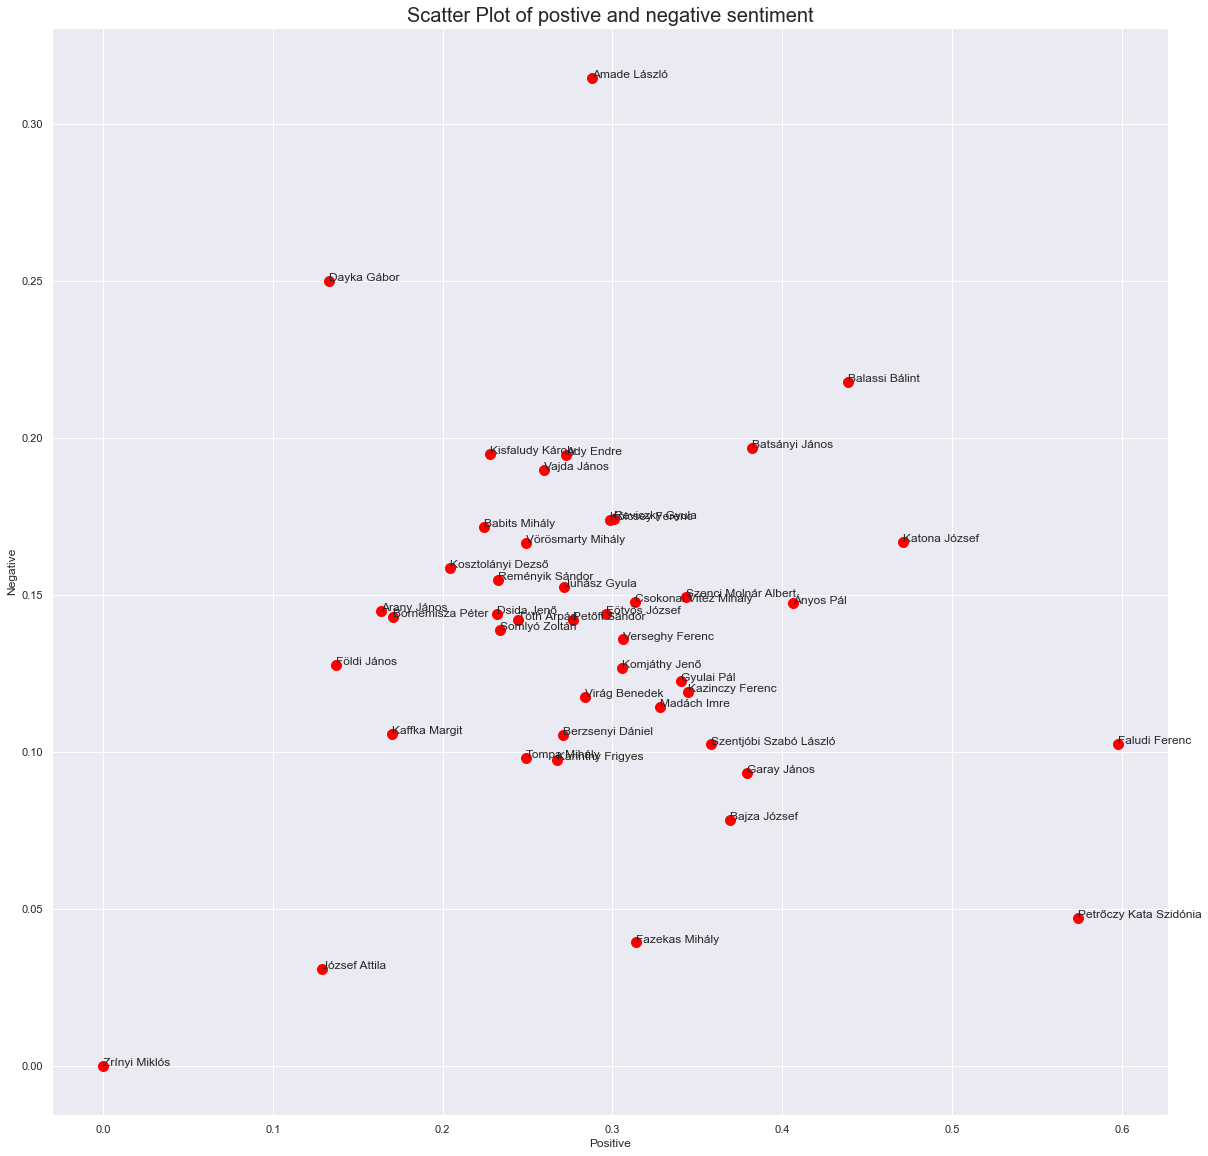

In [113]:
import numpy as np
import matplotlib.pyplot as plt

X = df_q1_pivot_1["positive"]
Y = df_q1_pivot_1["negative"]

annotations=df_q1_pivot_1["author"]

plt.figure(figsize=(20,20))
plt.scatter(X,Y,s=100,color="red")
plt.xlabel("Positive")
plt.ylabel("Negative")
plt.title("Scatter Plot of postive and negative sentiment",fontsize=20)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

### Sentiment trand through time

Based on the uneven data points in time, it was only possible to check sentiments by centuries. This shows minimal variation through time. We can see that the 20th cetnury has the lower positive sentiments, which is logicall based on the history of Hungary

In [114]:
# pivot by century
df_q1["century"] = df_q1["birth"].apply(lambda x: pd.to_numeric(str(x)[0:2])+1)
df_q1

# pivot by author

t3 = df_q1.groupby("century")["negative"].mean().reset_index()
t4 = df_q1.groupby("century")["positive"].mean().reset_index()
df_q1_pivot_1 = pd.merge(t3,t4)
df_q1_pivot_1.sort_values(['positive'], ascending=[False])

,century,negative,positive
1,17,0.031333,0.382667
0,16,0.173818,0.362273
2,18,0.152310,0.298595
3,19,0.154239,0.261739
4,20,0.141660,0.230196


### Q2: Classification of poetry by poets using Naive_Bayes

I will select the 3 authors with the most poems for classification analysis

In [115]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [116]:
authors = ("Juhász Gyula", "Ady Endre", "Dsida Jenő")

In [117]:
df = pd.read_csv("./talalatok.tsv", sep='\t')
df = pd.DataFrame(df)
df = df.rename(columns={"Szerző":"author", "Műcím":"title", "Webcím":"url"})
df.head(5)

,author,title,url
0,Ady Endre,»A BÁNAT DALAI«-BÓL,https://verskorpusz.elte-dh.hu/view.php?id=1858
1,Ady Endre,»A XXX-IK SZÁZADBÓL«,https://verskorpusz.elte-dh.hu/view.php?id=1458
2,Ady Endre,"»ÁDÁM, HOL VAGY?«",https://verskorpusz.elte-dh.hu/view.php?id=1304
3,Ady Endre,»ADÁNAK«,https://verskorpusz.elte-dh.hu/view.php?id=1636
4,Ady Endre,"»ÖRVENDEZZ, IFJÚ, IFJÚSÁGODBAN«",https://verskorpusz.elte-dh.hu/view.php?id=1325


In [118]:
df_q2 = df[(df.author == "Juhász Gyula") | (df.author == "Ady Endre") | (df.author == "Dsida Jenő")]
df_q2['author'].value_counts()

Juhász Gyula    1278
Ady Endre       1116
Dsida Jenő      1060
Name: author, dtype: int64

I scraped the text of the poems based on the given url

In [119]:
# poems = []
# poem = []

# for url in df_q2["url"]:
#    poem=[]
#    print(url)
#    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
#    for word in soup.find_all('span', class_='word'):
#        poem.append(word.text)
#    poems.append(" ".join(poem))

In [120]:
# df_q2["poem"] = poems
# df_q2.to_csv('./df_q2.csv', index=False)

#### Checking the data

In [121]:
df_q2 = pd.read_csv("./df_q2.csv")
df_q2

,author,title,url,poem
0,Ady Endre,»A BÁNAT DALAI«-BÓL,https://verskorpusz.elte-dh.hu/view.php?id=1858,"Mikor megláttalak , új életre keltem , Kínos é..."
1,Ady Endre,»A XXX-IK SZÁZADBÓL«,https://verskorpusz.elte-dh.hu/view.php?id=1458,"Jó fiam , ma minden magyar elválik , Ki messze..."
2,Ady Endre,"»ÁDÁM, HOL VAGY?«",https://verskorpusz.elte-dh.hu/view.php?id=1304,"Oszlik lelkemnek barna gyásza : Nagy , fehér f..."
3,Ady Endre,»ADÁNAK«,https://verskorpusz.elte-dh.hu/view.php?id=1636,"Halkult , rejtő és becéző szavak , Ti akkor is..."
4,Ady Endre,"»ÖRVENDEZZ, IFJÚ, IFJÚSÁGODBAN«",https://verskorpusz.elte-dh.hu/view.php?id=1325,Ajándékodból egy csipetnyi Maradt az alkonyi ó...
...,...,...,...,...
3449,Juhász Gyula,Zászlók,https://verskorpusz.elte-dh.hu/view.php?id=9251,"A múzeumban vannak régi zászlók , Csukott szár..."
3450,Juhász Gyula,Zene,https://verskorpusz.elte-dh.hu/view.php?id=8824,"Az ember , amíg fiatal , erős , Úgy véli , hog..."
3451,Juhász Gyula,"Zrinyi, a költő",https://verskorpusz.elte-dh.hu/view.php?id=8564,Sötéten csillogó bogyószemed Mély századok éjé...
3452,Juhász Gyula,Zsolozsma [1],https://verskorpusz.elte-dh.hu/view.php?id=9512,"Szeretlek téged , rejtelmes szemű , Titokzatos..."


In [122]:
df_q2["author"].value_counts()

Juhász Gyula    1278
Ady Endre       1116
Dsida Jenő      1060
Name: author, dtype: int64

There are some very long poems which I will exclude from my analysis for pratical reasons (above the 75% percentile, which is 1146 words)

In [123]:
df_q2['length'] = df_q2['poem'].apply(len)
df_q2.length.describe()

count     3454.000000
mean       680.967863
std        668.786786
min         40.000000
25%        426.000000
50%        544.500000
75%        747.000000
max      16995.000000
Name: length, dtype: float64

In [124]:
df_q2.sort_values(['length'], ascending=[False]).head(5)

,author,title,url,poem,length
1691,Dsida Jenő,Kóborló délután kedves kutyámmal,https://verskorpusz.elte-dh.hu/view.php?id=3938,"Szép farkaskutya , Tinti , örülj ! Leakasztom ...",16995
1800,Dsida Jenő,Miért borultak le az angyalok Viola előtt,https://verskorpusz.elte-dh.hu/view.php?id=3796,"Bocsánat , olvasóm , ki mostig üldögéltél újsá...",14853
1816,Dsida Jenő,Mirtha,https://verskorpusz.elte-dh.hu/view.php?id=3013,"Vén , szürke holló mondta el nekem , gubbaszko...",8499
1935,Dsida Jenő,Psalmus Hungaricus,https://verskorpusz.elte-dh.hu/view.php?id=3730,Vagy félezernyi dalt megírtam s e szót : magya...,7791
1649,Dsida Jenő,Kalendárium szonettekben,https://verskorpusz.elte-dh.hu/view.php?id=3252,"Barát vagyok , fiatal , vézna , ványadt : Halk...",7154


In [125]:
df_q2 = df_q2[df_q2["length"] < 1200]
df_q2.length.describe()

count    3206.000000
mean      562.711790
std       222.348332
min        40.000000
25%       415.000000
50%       524.000000
75%       695.750000
max      1198.000000
Name: length, dtype: float64

<AxesSubplot:ylabel='Frequency'>

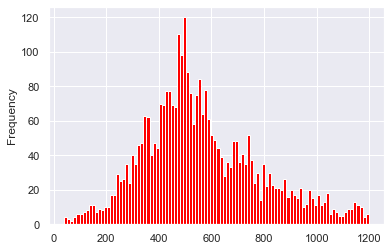

In [126]:
df_q2['length'].plot(bins=100, kind='hist', color='red')

array([[<AxesSubplot:title={'center':'Ady Endre'}>,
        <AxesSubplot:title={'center':'Dsida Jenő'}>],
       [<AxesSubplot:title={'center':'Juhász Gyula'}>, <AxesSubplot:>]],
      dtype=object)

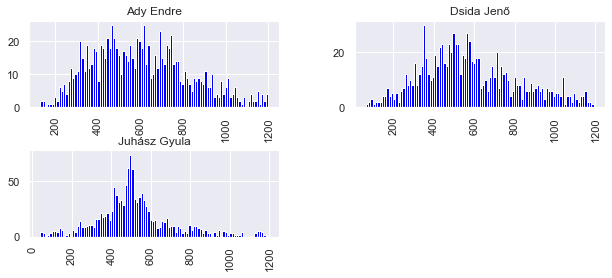

In [127]:
df_q2.hist(column='length', by='author',color='blue', bins=100, figsize=(10,4))

#### Tex processing

In [128]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [129]:
stopwords = stopwords.words('hungarian')# Show the vector of stop words

In [130]:
# adding custom stopwords
custom_words = ["ó", "kis", "en", "te","ot","előtt","ha", "mi","ti","ők", "őket", "oly"]
stopwords = stopwords + custom_words
stopwords

['a',
 'ahogy',
 'ahol',
 'aki',
 'akik',
 'akkor',
 'alatt',
 'által',
 'általában',
 'amely',
 'amelyek',
 'amelyekben',
 'amelyeket',
 'amelyet',
 'amelynek',
 'ami',
 'amit',
 'amolyan',
 'amíg',
 'amikor',
 'át',
 'abban',
 'ahhoz',
 'annak',
 'arra',
 'arról',
 'az',
 'azok',
 'azon',
 'azt',
 'azzal',
 'azért',
 'aztán',
 'azután',
 'azonban',
 'bár',
 'be',
 'belül',
 'benne',
 'cikk',
 'cikkek',
 'cikkeket',
 'csak',
 'de',
 'e',
 'eddig',
 'egész',
 'egy',
 'egyes',
 'egyetlen',
 'egyéb',
 'egyik',
 'egyre',
 'ekkor',
 'el',
 'elég',
 'ellen',
 'elõ',
 'elõször',
 'elõtt',
 'elsõ',
 'én',
 'éppen',
 'ebben',
 'ehhez',
 'emilyen',
 'ennek',
 'erre',
 'ez',
 'ezt',
 'ezek',
 'ezen',
 'ezzel',
 'ezért',
 'és',
 'fel',
 'felé',
 'hanem',
 'hiszen',
 'hogy',
 'hogyan',
 'igen',
 'így',
 'illetve',
 'ill.',
 'ill',
 'ilyen',
 'ilyenkor',
 'ison',
 'ismét',
 'itt',
 'jó',
 'jól',
 'jobban',
 'kell',
 'kellett',
 'keresztül',
 'keressünk',
 'ki',
 'kívül',
 'között',
 'közül',
 'lega

In [131]:
def remove_punct_tokenize(text):
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()   
    return text.split()  

def remove_stopwords(text):
    clean_stopwords=""
    for element in remove_punct_tokenize(text):
        if element not in stopwords:
            clean_stopwords = clean_stopwords + " "+ element
    return clean_stopwords.strip()

In [132]:
df_q2['poem'] = df_q2['poem'].apply(remove_stopwords)

C:\Users\Dani\AppData\Local\Temp/ipykernel_8144/1620434100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q2['poem'] = df_q2['poem'].apply(remove_stopwords)


In [133]:
df_q2 = df_q2[["author","poem"]]
df_q2.head(5)

,author,poem
0,Ady Endre,megláttalak életre keltem kínos élet zordon mu...
1,Ady Endre,fiam ma magyar elválik messze messzebb magánál...
2,Ady Endre,oszlik lelkemnek barna gyásza fehér fényben jö...
3,Ady Endre,halkult rejtő becéző szavak is mellette leszte...
4,Ady Endre,ajándékodból csipetnyi maradt alkonyi órákra u...


#### Get bow vectorizer

In [134]:
# !pip install sklearn

In [135]:
from sklearn.feature_extraction.text import CountVectorizer

In [136]:
#CountVectorizer will convert text into token counts
bow_transformer = CountVectorizer()

In [137]:
bow_transformer = CountVectorizer(preprocessor = remove_stopwords).fit(df_q2['poem'])

#### Transform poems

In [138]:
data_bow = bow_transformer.transform(df_q2['poem'])

#### Tf-IDF transformation

In [139]:
from sklearn.feature_extraction.text import TfidfTransformer

In [140]:
tfidf_transformer = TfidfTransformer().fit(data_bow)

In [141]:
data_tfidf = tfidf_transformer.transform(data_bow)
print (data_tfidf.shape)

(3206, 48576)


In [142]:
data_tfidf

<3206x48576 sparse matrix of type '<class 'numpy.float64'>'
	with 161511 stored elements in Compressed Sparse Row format>

#### Naive Bayes Classifier

In [143]:
from sklearn.naive_bayes import MultinomialNB

In [144]:
author_detect_model = MultinomialNB()

#### Train test split

In [145]:
from sklearn.model_selection import train_test_split
poem_train, poem_test, author_train, author_test = train_test_split(df_q2["poem"], df_q2["author"], test_size=0.2, random_state=1, stratify=df_q2['author'])

In [146]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
#create pipeline
pipeline = Pipeline([
    ('tfidf', CountVectorizer(preprocessor = remove_stopwords )),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  #Naive Bayes classifier
])

In [147]:
pipeline.fit(poem_train, author_train)
predictions = pipeline.predict(poem_test)

Results show an 80-91% accuracy for the authors. This is pretty good, given that the benchmark random classification would have a 33% accuracy

In [148]:
from sklearn.metrics import classification_report
print (classification_report(author_test,  predictions))

              precision    recall  f1-score   support

   Ady Endre       0.91      0.80      0.85       202
  Dsida Jenő       0.92      0.79      0.85       194
Juhász Gyula       0.80      0.96      0.87       246

    accuracy                           0.86       642
   macro avg       0.87      0.85      0.86       642
weighted avg       0.87      0.86      0.86       642



In [161]:
from sklearn.metrics import confusion_matrix
#tn, fp, fn, tp = confusion_matrix(label_test,predictions).ravel()
confusion_matrix(author_test, predictions)

array([[162,   9,  31],
       [ 11, 154,  29],
       [  6,   4, 236]], dtype=int64)

I made a dataframe from the test test and the predicted labels

In [149]:
test = pd.DataFrame(list(zip(poem_test,author_test, predictions)), columns=['poem','author', 'prediction'])
test["difference"] = test["author"] == test["prediction"] 

In [162]:
test

,poem,author,prediction,difference
0,gyermekek játszadoznak déli sugaras utcán belé...,Ady Endre,Ady Endre,True
1,szerelmünk hidd bárki szeretné hinni édes édes...,Dsida Jenő,Ady Endre,False
2,magyar éjben fölzokognak siralmaid véres száza...,Juhász Gyula,Juhász Gyula,True
3,semmirevalónak gácsnak svábnak zsidónak grádic...,Ady Endre,Ady Endre,True
4,elmúlok szelíden álom följárok bús téli éjszak...,Juhász Gyula,Juhász Gyula,True
...,...,...,...,...
637,fáradt karokkal kesergőn hideg síneket szorito...,Ady Endre,Ady Endre,True
638,halottak halottak bennem künnkünn szerteszéjje...,Ady Endre,Ady Endre,True
639,istenem földben fűben kőben bántsuk egymást mo...,Ady Endre,Ady Endre,True
640,búsult csüggeteg árva adtam magam paráznaságra...,Ady Endre,Ady Endre,True


In [150]:
test["difference"].value_counts()

True     552
False     90
Name: difference, dtype: int64

Results by author show that Juhász Gyula could be classified the best

<AxesSubplot:xlabel='author', ylabel='count'>

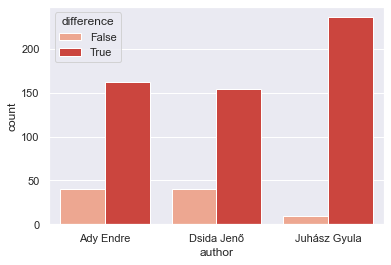

In [168]:
sns.countplot(x='author', hue="difference", data=test, palette="Reds")